# Imports

In [101]:
# read files
import json
import urllib.request 
import re, os
import sys

# preprocessing, math
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# helper functions
from helperFunctions import *

# naive bayes
from naiveBayes import *

# Load dataset

In [58]:
# Source: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification?resource=download
datapath = r"C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\"
df = readDataset(datapath)
df.label = df.label.apply(lambda x: x.replace(datapath, ''))

Directory:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\
Subdir:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\
Directory:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\business
Subdir:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\business
Directory:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\entertainment
Subdir:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\entertainment
Directory:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\politics
Subdir:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignment\input\bbc-fulltext(document-classification)\bbc\\politics
Directory:  C:\Users\Chris\Desktop\Master\Ajou\NLP\assignm

In [59]:
df.shape

(2225, 2)

# Analyse and Preprocess

missing labels

In [60]:
df.isnull().sum()

text     0
label    0
dtype: int64

classes

In [61]:
df.label.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

is the dataset balanced?

(<AxesSubplot:>,
 sport            511
 business         510
 politics         417
 tech             401
 entertainment    386
 Name: label, dtype: int64)

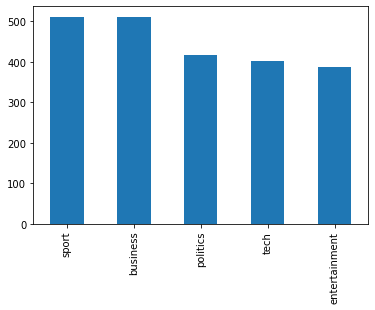

In [62]:
counts = df['label'].value_counts().sort_values(ascending=False)
counts.plot(kind='bar'), counts

Numeric Labels

In [63]:
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head()

,text,label
0,Quarterly profits at US media giant TimeWarn...,0
1,The dollar has hit its highest level against...,0
2,The owners of embattled Russian oil giant Yu...,0
3,British Airways has blamed high fuel prices ...,0
4,Shares in UK drinks and food firm Allied Dom...,0


Clean text, remove/replace symbols and stopwords

In [64]:
df['text'] = df['text'].apply(cleanNLFeature)
# remove digits
df['text'] = df['text'].str.replace('\d+', '')
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\User

,text,label
0,quarterly profits us media giant timewarner ju...,0
1,dollar hit highest level euro almost three mon...,0
2,owners embattled russian oil giant yukos ask b...,0
3,british airways blamed high fuel prices drop ...,0
4,shares uk drinks food firm allied domecq risen...,0


Create train, validation, test split

In [65]:
# train val test relation -> 60:20:20
trainval, test = train_test_split(df, test_size=0.2, random_state=12345)
train, val = train_test_split(trainval, test_size=0.25, random_state=12345)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
train.head()

,text,label
0,general motors gm saw net profits fall last q...,0
1,mark philippoussis withdrew sydney internation...,3
2,angolan families attempting track separated ne...,1
3,european parliament thrown bill would allowed ...,4
4,verizon takeover battle us phone firm mci bid ...,0


In [66]:
train.shape, val.shape, test.shape

((1335, 2), (445, 2), (445, 2))

Create Frequency Table

In [67]:
# ~cubic complexity, very time consuming
freq_tb, uniques = frequencyTable(train)

In [68]:
freq_tb

array([[ 48.,  10., 118.,   7.,  24.],
       [ 17.,   1.,   0.,   0.,   0.],
       [ 28.,   0.,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0.,   0.]])

Create likelyhood table

In [69]:
# no need to merge all information into one table
sumRowsRel, sumColsRel = likelihoodTable(freq_tb)  

# Apply Naive Bayes

prep validation set

In [70]:
#prob = predict(hypothesis, event, uniques, freq_tb, sumRowsRel, sumColsRel)
y_val = val.label
val.drop('label', axis=1, inplace=True, errors='ignore')

In [97]:
# an unseen document
doc = 345
document = val.text[doc]

In [99]:
# predict class for document
predictDoc(document, uniques, freq_tb, sumRowsRel, sumColsRel)

1

In [100]:
y_val[doc]

1

run prediction for the entire validation set

In [102]:
y_pred = []
for d in val.text:
    y_pred.append(predictDoc(d, uniques, freq_tb, sumRowsRel, sumColsRel))

NameError: name 'predictDoc' is not defined